In [47]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from models import functions

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [48]:
df = pd.read_csv('notebook/NRZ_history.csv', index_col=0)

In [49]:
df.head()

,close,volume,vwap,changeOverTime
2015-05-18,17.45,1611500.0,17.38000,0.01159
2015-05-19,17.78,2060800.0,17.70000,0.01716
2015-05-20,17.64,2145700.0,17.69000,-0.00899
2015-05-21,17.20,1205200.0,17.20000,-0.00232
2015-05-22,17.39,1476200.0,17.31667,0.01340


In [50]:
TRAIN_SPLIT = int(len(df)*0.8)

In [51]:
TRAIN_SPLIT

1007

In [52]:
# constants 
EVALUATION_INTERVAL = 65
EPOCHS = 10

BATCH_SIZE = 20
BUFFER_SIZE = 10000

In [53]:
features_considered = ['close', 'vwap']

close      vwap
2015-05-18  17.45  17.38000
2015-05-19  17.78  17.70000
2015-05-20  17.64  17.69000
2015-05-21  17.20  17.20000
2015-05-22  17.39  17.31667
...           ...       ...
2020-05-11   6.31   6.34667
2020-05-12   6.11   6.19333
2020-05-13   5.66   5.71667
2020-05-14   6.09   5.83333
2020-05-15   5.91   5.98667

[1259 rows x 2 columns]


,close,vwap
2015-05-18,17.45,17.38000
2015-05-19,17.78,17.70000
2015-05-20,17.64,17.69000
2015-05-21,17.20,17.20000
2015-05-22,17.39,17.31667


2015-05-18    17.45
2015-05-19    17.78
2015-05-20    17.64
2015-05-21    17.20
2015-05-22    17.39
              ...  
2020-05-11     6.31
2020-05-12     6.11
2020-05-13     5.66
2020-05-14     6.09
2020-05-15     5.91
Name: close, Length: 1259, dtype: float64


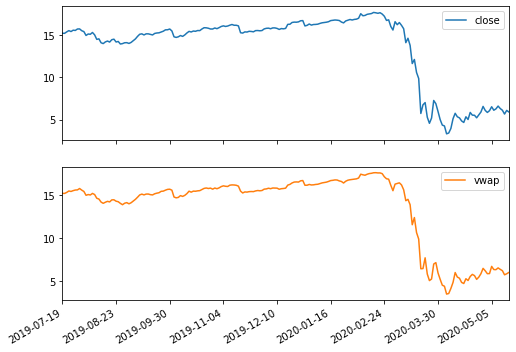

In [54]:
features = df[features_considered]
print(features)
features[1050:].plot(subplots=True)
display(features.head())
print(features.iloc[:, 0])

In [55]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [56]:
# dataset = (dataset-data_mean)/data_std

In [57]:
dataset[:, 0]

array([17.45, 17.78, 17.64, ...,  5.66,  6.09,  5.91])

In [58]:
print(len(dataset))

1259


In [59]:
past_history = 50 # how many past days to consider
future_target = 5 # how many days to predict in the future 
STEP = 1

x_train_single, y_train_single = functions.multivariate_data(dataset, dataset[:, 0], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step=True)

x_val_single, y_val_single = functions.multivariate_data(dataset, dataset[:, 0], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step=True)

In [60]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))
print ('\n Target price to predict : {}'.format(y_train_single[0].shape))

Single window of past history : (50, 2)

 Target price to predict : ()


In [61]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [62]:
train_data_single

<RepeatDataset shapes: ((None, 50, 2), (None,)), types: (tf.float64, tf.float64)>

In [63]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [64]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(20, 1)


In [65]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 65 steps, validate for 50 steps
Epoch 1/10
65/65 [==============================] - 3s 53ms/step - loss: 12.3440 - val_loss: 7.6170
Epoch 2/10
65/65 [==============================] - 2s 29ms/step - loss: 7.4457 - val_loss: 5.2787
Epoch 3/10
65/65 [==============================] - 2s 26ms/step - loss: 4.8237 - val_loss: 4.2227
Epoch 4/10
65/65 [==============================] - 2s 26ms/step - loss: 2.7473 - val_loss: 3.5165
Epoch 5/10
65/65 [==============================] - 2s 26ms/step - loss: 2.4556 - val_loss: 2.8717
Epoch 6/10
65/65 [==============================] - 2s 26ms/step - loss: 2.1964 - val_loss: 3.1601
Epoch 7/10
65/65 [==============================] - 2s 27ms/step - loss: 1.6790 - val_loss: 2.4608
Epoch 8/10
65/65 [==============================] - 2s 28ms/step - loss: 1.2604 - val_loss: 2.6982
Epoch 9/10
65/65 [==============================] - 2s 34ms/step - loss: 1.0425 - val_loss: 3.0160
Epoch 10/10
65/65 [==============================] - 2s 36ms/step 

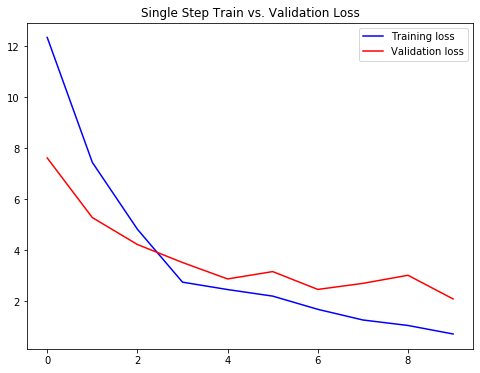

In [66]:
functions.plot_train_history(single_step_history, 'Single Step Train vs. Validation Loss')

In [67]:
print(val_data_single)

<RepeatDataset shapes: ((None, 50, 2), (None,)), types: (tf.float64, tf.float64)>


[array([16.62, 16.53, 16.6 , 16.59, 16.52, 16.52, 16.4 , 15.98, 15.59,
       15.25, 15.48, 15.85, 15.72, 15.74, 15.13, 15.32, 15.36, 15.42,
       15.55, 15.46, 15.58, 15.77, 15.84, 15.83, 15.89, 16.01, 15.64,
       15.72, 15.84, 15.39, 15.46, 15.33, 15.42, 15.56, 15.4 , 15.3 ,
       15.3 , 15.29, 15.41, 15.45, 15.37, 15.28, 15.04, 15.18, 15.17,
       15.34, 15.49, 15.38, 15.54, 15.51]), 15.09, array([16.271215], dtype=float32)]
1


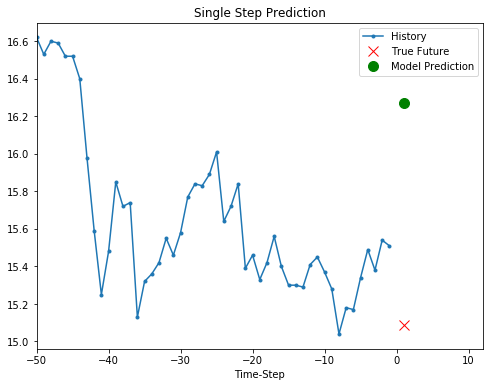

[array([15.58, 15.77, 15.84, 15.83, 15.89, 16.01, 15.64, 15.72, 15.84,
       15.39, 15.46, 15.33, 15.42, 15.56, 15.4 , 15.3 , 15.3 , 15.29,
       15.41, 15.45, 15.37, 15.28, 15.04, 15.18, 15.17, 15.34, 15.49,
       15.38, 15.54, 15.51, 15.68, 15.69, 15.48, 15.37, 14.92, 15.09,
       15.06, 15.27, 14.99, 14.46, 14.52, 14.06, 13.96, 14.16, 14.26,
       14.14, 14.42, 14.48, 14.15, 14.21]), 14.1, array([15.915026], dtype=float32)]
2


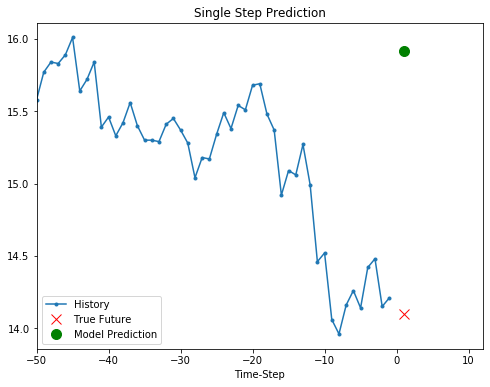

[array([15.37, 15.28, 15.04, 15.18, 15.17, 15.34, 15.49, 15.38, 15.54,
       15.51, 15.68, 15.69, 15.48, 15.37, 14.92, 15.09, 15.06, 15.27,
       14.99, 14.46, 14.52, 14.06, 13.96, 14.16, 14.26, 14.14, 14.42,
       14.48, 14.15, 14.21, 13.91, 13.96, 14.06, 14.07, 13.98, 14.1 ,
       14.31, 14.51, 14.81, 15.06, 15.11, 14.98, 15.11, 15.11, 15.05,
       14.98, 15.16, 15.21, 15.23, 15.33]), 14.76, array([16.171526], dtype=float32)]
3


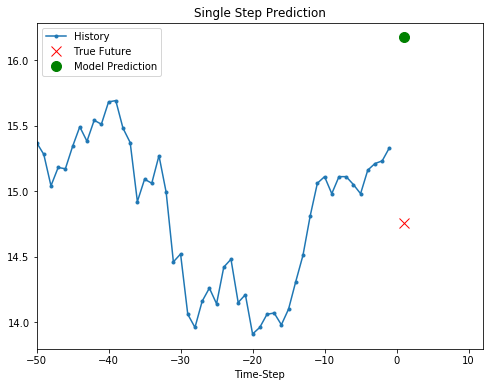

In [75]:
count = 0
for x, y in val_data_single:
    print([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]])
    plot = functions.show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
    count = count + 1
    print (count)
    plot.show()